In [1]:
import h5py
import keras
import tensorflow as tf

# Silence deprecated-function warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Confirming versions
print(keras.__version__, tf.__version__, h5py.__version__)

Using TensorFlow backend.


2.2.5 1.15.0 2.10.0


In [2]:
import os
import json
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath("./")

from mrcnn.config import Config
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn import utils

# Path to trained weights file
COCO_WEIGHTS_PATH = "../mask_rcnn_coco.h5"
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = 256
    IMAGE_MIN_DIM = 156
    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + (Horse and Man)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [3]:
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  156
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [4]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "Horse")
        self.add_class("object", 2, "Man")
        # self.add_class("object", 3, "xyz") #likewise

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinates of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Horse": 1,"Man": 2} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Horse/Man dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
def train(model, dataset_train, dataset_val, epochs = 1):
    """Train the model."""
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epochs,
                layers='heads')

In [6]:
dataset_train = CustomDataset()
dataset_train.load_custom("./dataset", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("./dataset", "val")
dataset_val.prepare()

objects: ['Man', 'Horse', 'Man', 'Horse', 'Man']
numids [2, 1, 2, 1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man', 'Man']
numids [1, 2, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Man', 'Horse', 'Horse', 'Man']
numids [2, 1, 1, 2]
objects: ['Man', 'Horse', 'Man', 'Man', 'Man', 'Horse', 'Horse', 'Horse']
numids [2, 1, 2, 2, 2, 1, 1, 1]


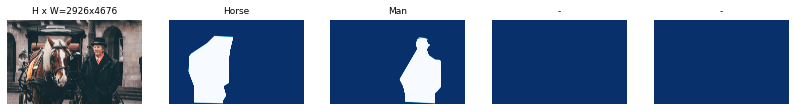

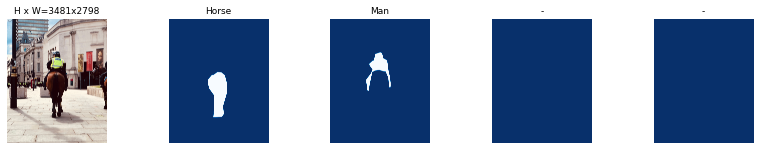

In [7]:
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [8]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [9]:
train(model, dataset_train, dataset_val, epochs = 1)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: c:\Users\bhavy\MoNuSAC-Instance-Segmentation\test\logs\object20211203T0125\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)


c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
100/100 [==============================] - 477s 5s/step - loss: 0.8329 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.3327 - mrcnn_mask_loss: 0.3348 - val_loss: 0.9361 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.2023 - val_mrcnn_class_loss: 0.0888 - val_mrcnn_bbox_loss: 0.3320 - val_mrcnn_mask_loss: 0.3036
